# Preliminary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
from collections import defaultdict
import constants
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict
from cop_kmeans import cop_kmeans
import itertools
from itertools import combinations

plt.rcParams['text.usetex'] = True

### Negative Log Bayes Factor

This was previously numerically inaccurate because the $\kappa_{(i,c)}$ in radians for the real data is on the order of $10^{13}$. However, we always take the $\log$ of those terms. So, we can utilize the following more numerically accurate calculation:

Let $\kappa_{(i,c)}$ be in $\text{arcseconds}^{-2}$. Then, to convert to $\text{rad}^{-2}$, we multiply by $C=\log((\pi/180/3600)^{-2})$. $C$ is the large number which makes the numerical calculations inaccurate. Then, we can use the following identities to keep all intermediate numbers small:
$$
\sum_{(i,c)\in O} \log(C\kappa_{(i,c)}) = \sum_{(i,c)\in O} (\log(C) + \log(\kappa_{(i,c)})) = |S_o|\log(C) +  \sum_{(i,c)\in O}\log(\kappa_{(i,c)}))
$$
$$
\log\left(\sum_{(i,c)\in O} C\kappa_{(i,c)}\right) = \log\left(C\sum_{(i,c)\in O} \kappa_{(i,c)}\right) = \log(C) + \log\left(\sum_{(i,c)\in O} \kappa_{(i,c)}\right)
$$

In [ ]:
from matching import neg_log_bayes, run_kmeans, run_cop_kmeans, run_cop_kmeans_single

### MIQCP

In [5]:
from gurobipy import Model, GRB, quicksum
from scipy.spatial.distance  import pdist
import itertools
from collections import defaultdict

def miqcp(data_df: pd.DataFrame, max_clusters = -1):
    num_datapoints = data_df.shape[0]
    num_clusters = max_clusters
    if max_clusters == -1:
        num_clusters = num_datapoints
    num_catalogs = data_df["ImageID"].unique().shape[0]
    dims = 2
    
    C = np.log(constants.ARCSEC_TO_RAD_2) # constant used for arcseconds to radians conversion

    model = Model("MIQCP")

    # Make intermediate lists and dictionaries
    candidate_list = []
    coord_dict = dict()
    kappa_dict = dict()
    kappa_rad_dict = dict()

    for _, row in data_df.iterrows():
        source_image = (row.SourceID, row.ImageID)
        candidate_list.append(source_image)
        coord_dict[source_image] = (row["coord1 (arcseconds)"],row["coord2 (arcseconds)"])
        kappa_dict[source_image] = row["kappa"]
        kappa_rad_dict[source_image] = row["kappa (radians)"]

    # Add cluster variables
    cluster_vars = model.addVars(num_clusters, dims, lb = -float('inf'), ub=float('inf'))

    # Add boolean variables (cluster-sources)
    x = model.addVars(candidate_list, list(range(num_clusters)), vtype=GRB.BINARY)

    for (source, catalog, k), var in x.items():
        var.setAttr("BranchPriority", 1)

    # cluster distances
    p = model.addVars(num_clusters, lb = 0, vtype=GRB.BINARY)

    # Add M variable
    M = np.max(pdist(data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]])) * data_df["kappa"].max() * 1.1
    # M = 10**6
    
    # Add max cluster distance variables
    r_dict = model.addVars(candidate_list, lb = 0.0, ub = float('inf'))

    # Log term
    rounding_index = -2
    error_threshold = 1/100 * (np.log(data_df["kappa"].min()) + C)

    var_chi_dict = {}
    sigma_max = data_df["Sigma"].max()
    sigma_min = data_df["Sigma"].min()
    
    # b_list = [np.log(1/(sigma_max)**2) + C]
    b_list = [np.log(1/(sigma_max)**2)]
    # Compute b_list
    # while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2) + C:
    while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2):
        b_list.append(b_list[-1]+error_threshold)
        
    num_breakpoints = len(b_list) # = P in the paper

    # Variables for chi
    for j in range(num_clusters):
        for b_i in range(num_breakpoints):
            var_chi_dict[('chi', j, b_i)] = model.addVar(vtype=GRB.BINARY, name=str(('chi', j, b_i)))

    s = model.addVars(num_clusters, lb = 0, vtype=GRB.INTEGER)
    
    ### Objective ###
    sum_ln_kappa_rad = (C * num_datapoints) + np.log(data_df["kappa"]).sum()
    model.setObjective((0.5 * r_dict.sum()) 
                       + (np.log(2) * p.sum()) 
                       - (np.log(2) * s.sum())
                        + quicksum((b_list[0] * var_chi_dict[('chi', j, 0)])
                                    + (error_threshold * quicksum(var_chi_dict[('chi', j, b_i)] 
                                                                  for b_i in range(1,num_breakpoints)))
                                    for j in range(num_clusters))
                       + (p.sum() * C)
                       - sum_ln_kappa_rad
                        , GRB.MINIMIZE)

    ### Constraints
    # Each point assigned to a cluster
    for source, catalog in candidate_list:
        model.addConstr(quicksum(x[(source, catalog, j)] for j in range(num_clusters)) == 1)

    # |# objects| * ln(2)
    # p = 1 if there is a source in that cluster
    # p = 0 if no sources assigned to cluster
    for j in range(num_clusters):
        for source, catalog in candidate_list:
            model.addConstr(p[j] >= x[source,catalog,j])
            
    # |# sources| * ln(2)
    for j in range(num_clusters):
        model.addConstr(s[j] == quicksum(x[source,catalog,j] for source,catalog in candidate_list))

    # Each cluster has at most one source from a catalog
    sources_by_catalog = defaultdict(list)
    for source, catalog in candidate_list:
        sources_by_catalog[catalog].append(source)

    for j,c in itertools.product(range(num_clusters), range(num_catalogs)):
        model.addConstr(quicksum(x[(source,c,j)] for source in sources_by_catalog[c]) <= 1)

    # Min and max for cluster variables
    # Get coordinates
    x_coords = data_df["coord1 (arcseconds)"]
    y_coords = data_df["coord2 (arcseconds)"]

    for j in range(num_clusters):
        model.addConstr(cluster_vars[j,0] == [min(x_coords), max(x_coords)])
        model.addConstr(cluster_vars[j,1] == [min(y_coords), max(y_coords)])

    # Break symmetry
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1)

    # Big-M constraints
    for (source, catalog), coord in coord_dict.items():
        for j in range(num_clusters):
            model.addQConstr((kappa_dict[(source,catalog)] * # in arcseconds^-2
                              (((cluster_vars[j,0] - coord[0]) * (cluster_vars[j,0] - coord[0])) + 
                               ((cluster_vars[j,1] - coord[1]) * (cluster_vars[j,1] - coord[1])))) # in arcseconds ^ 2
                             <= 
                             r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)])))
    
    # Definition of variables chi
    # Equation B19
    for j in range(num_clusters):
        chi_constraint_with_b = []
        chi_constraint = []
        x_constraint = []
        for breakpoint_index in range(1, num_breakpoints):
            #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
            # chi_constraint_with_b.append(var_chi_dict[('chi', j, breakpoint_index)]*(np.exp(b_list[breakpoint_index])-np.exp(b_list[breakpoint_index-1]))/10**10)
            chi_constraint_with_b.append(var_chi_dict[('chi', j, breakpoint_index)]*(np.exp(b_list[breakpoint_index])-np.exp(b_list[breakpoint_index-1])))
        for source, catalog in candidate_list:
            # x_constraint.append(x[(source, catalog, j)]*kappa_rad_dict[(source, catalog)]/10**10) 
            x_constraint.append(x[(source, catalog, j)]*kappa_dict[(source, catalog)]) 
            #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
        model.addConstr(np.exp(b_list[0])* var_chi_dict[('chi', j, 0)] + quicksum(variable for variable in chi_constraint_with_b) >= quicksum(variable for variable in x_constraint))
        
        for breakpoint_index in range(num_breakpoints):
            chi_constraint.append(var_chi_dict[('chi', j, breakpoint_index)])
        for chi_index in range(len(chi_constraint) - 1):
            model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])
    
    ### Solve MIQCP
    # model.setParam('NodefileStart', 5.0)
    # model.setParam("PreDual", 1)
    # model.setParam("PreQLinearize", 2)
    model.setParam("NumericFocus", 2) # for numerical stability

    model.optimize()

    labels = []
    for (source, catalog, j), var in x.items():
        if var.X > 0.5:
            labels.append(j)
    assert len(labels) == num_datapoints # sanity check that every point is assigned a label
    
    return pd.factorize(labels)[0] # factorize sets labels from 0 to max_labels

### Plot Methods

In [6]:
def plot_friends_of_friends(data_df):
    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.5, c = data_df.SubID, cmap='tab20')
    plt.title("Clustered via Single-Linkage\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_lined(labels, data_df):
    loc_tups = [(row["coord1 (arcseconds)"], row["coord2 (arcseconds)"]) for _, row in data_df.iterrows()]

    label_dict = defaultdict(list)
    for tup, label in zip(loc_tups, labels):
        label_dict[label].append(tup)
        
    plt.figure(figsize=(7,7))
    for label, tup_list in label_dict.items():
        if len(tup_list) == 1:
            pairs = [tup_list]
        else:
            pairs = list(combinations(tup_list, 2))
        for pair in pairs:
            x = []
            y = []
            for tup in pair:
                x.append(tup[0])
                y.append(tup[1])
            plt.plot(x, y, color='green', marker='o', linestyle='-', linewidth=1, markersize=2)
    
def plot_cop_kmeans(data_df, num_repeat = 10):
    best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0], num_repeat = num_repeat)

    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = best_labels, cmap='tab20')
    plt.title("Clustered via COP K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_cop_kmeans_lined(data_df, num_repeat = 10):
    best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0], num_repeat = num_repeat)
    plot_lined(best_labels, data_df)
    plt.title("Clustered via COP K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_friends_of_friends_lined(data_df):
    labels = list(data_df.SubID)
    plot_lined(labels, data_df)
    plt.title("Clustered via Single-Linkage\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_kmeans(data_df):
    best_labels, best_k, best_bayes = run_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0])

    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = best_labels, cmap='tab20')
    plt.title("Clustered via K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_kmeans_lined(data_df):
    best_labels, best_k, best_bayes = run_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0])
    plot_lined(best_labels, data_df)
    plt.title("Clustered via K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_miqcp(data_df, max_clusters = -1):
    labels = miqcp(data_df, max_clusters)
    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = labels, cmap='tab10')
    plt.title("Clustered via MIQCP\n"
                r"$-\sum_{{o\in O}}\log(B_o)=$"
                f"${neg_log_bayes(data_df, labels):.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Load medium-size data

In [12]:
data_path = 'data/match_4000710334517.csv'
data_df = pd.read_csv(data_path)

# Convert Image IDs to integers in range [0, number of images]
data_df.ImageID = pd.factorize(data_df.ImageID)[0]

# Get kappas (inverse of sigma)
data_df["kappa"] = 1 / (data_df["sigma"] ** 2)
data_df["kappa (radians)"] = 1 / ((data_df["sigma"]*np.pi/180/3600) ** 2)
data_df["log kappa (radians)"] = np.log(data_df["kappa (radians)"])

data_df.head()

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,sigma,kappa,kappa (radians),log kappa (radians)
0,4000710334517,0,269.749758,-29.186608,0,4001061039486,-0.003813,-0.873028,-0.487656,0.03655,748.557635,3.184751e+13,31.091980
1,4000710334517,0,269.749758,-29.186608,1,4001212780699,-0.003814,-0.873028,-0.487656,0.06405,243.759586,1.037079e+13,29.970015
2,4000710334517,0,269.749758,-29.186608,1,4001212780710,-0.003812,-0.873028,-0.487656,0.03850,674.650059,2.870310e+13,30.988026
3,4000710334517,0,269.749758,-29.186608,2,4001120525362,-0.003813,-0.873028,-0.487656,0.03395,867.601807,3.691227e+13,31.239565
4,4000710334517,0,269.749758,-29.186608,3,4001152086466,-0.003813,-0.873028,-0.487656,0.01605,3881.949811,1.651582e+14,32.737925


### Convert to 2D coordinates
Do dot product with tangent vectors (north and west) to get x and y (in radians) Blur is the same because it's the same instrument. 

In [3]:
counts = defaultdict(int)
for row in data_df.itertuples():
    counts[(row.RA, row.Dec)] += 1

# Calculate center of all objects in Ra and Dec
centers_ra_decs = list(counts.keys())
num_counts = sum(counts.values())
center_ra = sum(c[0] * counts[c] for c in centers_ra_decs) / num_counts
center_dec = sum(c[1] * counts[c] for c in centers_ra_decs) / num_counts

# Convert to west/north coordinates
center_west, center_north = tangent(center_ra, center_dec)

data_df["coord1 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df["coord2 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

### Friends of Friends

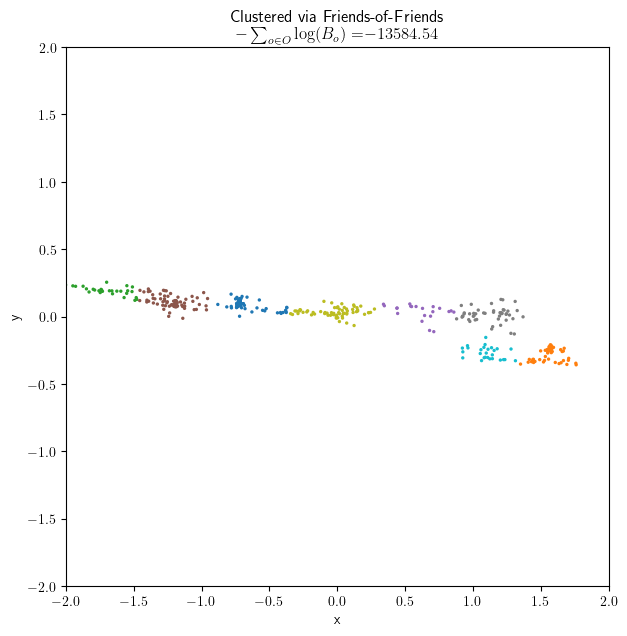

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### KMeans

100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


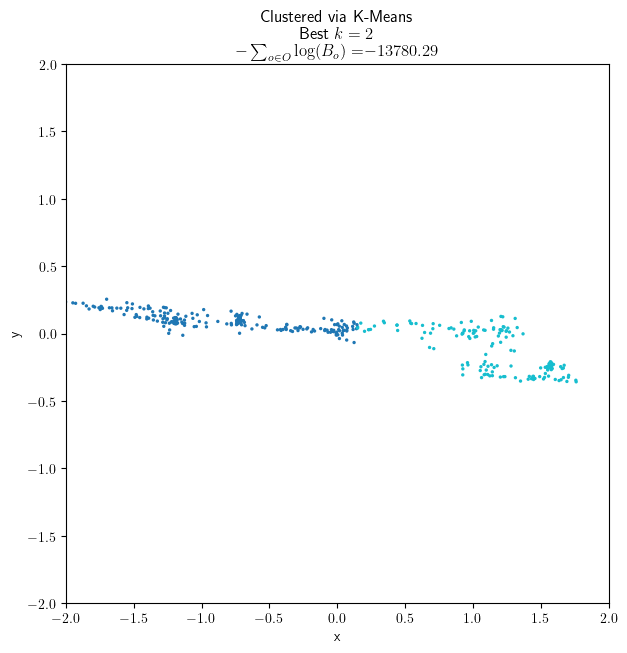

In [10]:
best_labels, best_k, best_bayes = run_kmeans(data_df, 1,50)

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### COP-KMeans

In [6]:
best_labels, best_k, best_bayes = run_cop_kmeans(data_df, 100, 101)

# plt.figure(figsize=(7,7))
# plt.scatter(data_df['coord1 (arcseconds)'],
#             data_df['coord2 (arcseconds)'],
#             s=2.0, c = best_labels, cmap='tab20')
# plt.title("Clustered via K-Means\n"
#           f"Best $k={best_k}$\n"
#               r"$-\sum_{{o\in O}}\log(B_o)=$"
#               f"${best_bayes:.2f}$")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
# plt.show()

100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


## Big Data

In [14]:
big_data_path = "big_data/MyHDF_jacobf18_0.csv"
big_data_df = pd.read_csv(big_data_path)

# Convert Image IDs to integers in range [0, number of images]
big_data_df.ImageID = pd.factorize(big_data_df.ImageID)[0]

# Get kappas (inverse of sigma)
big_data_df["kappa"] = 1 / (big_data_df.Sigma ** 2)
big_data_df["kappa (radians)"] = 1 / ((big_data_df.Sigma*np.pi/180/3600) ** 2)
big_data_df["log kappa (radians)"] = np.log(big_data_df["kappa (radians)"])

# Get center of data points
center_ra = big_data_df.RA.mean()
center_dec = big_data_df.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

big_data_df["coord1 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
big_data_df["coord2 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

big_data_df

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751,10.930064,-5.757109
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173,61.544402,-8.301104
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955,20.895535,-8.587093
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452,20.623653,-7.377742
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804,50.428467,-6.230797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500,55,35306,4600995538,4600995538,0.456473,-0.182048,-0.870914,0.10680,338.256965,-60.564915,87.671305,3.729991e+12,28.947427,-46.624523,-46.174268
60501,55,35306,4600995523,4600995523,0.456340,-0.182410,-0.870908,0.02490,338.211995,-60.564248,1612.877199,6.862014e+13,31.859607,32.937911,-43.786583
60502,55,35306,4600995488,4600995488,0.456445,-0.182132,-0.870911,0.07570,338.246640,-60.564574,174.505139,7.424351e+12,29.635786,-28.356915,-44.944932
60503,55,35306,4600995480,4600995480,0.456368,-0.182323,-0.870911,0.14380,338.222590,-60.564618,48.359547,2.057465e+12,28.352496,14.191576,-45.110163


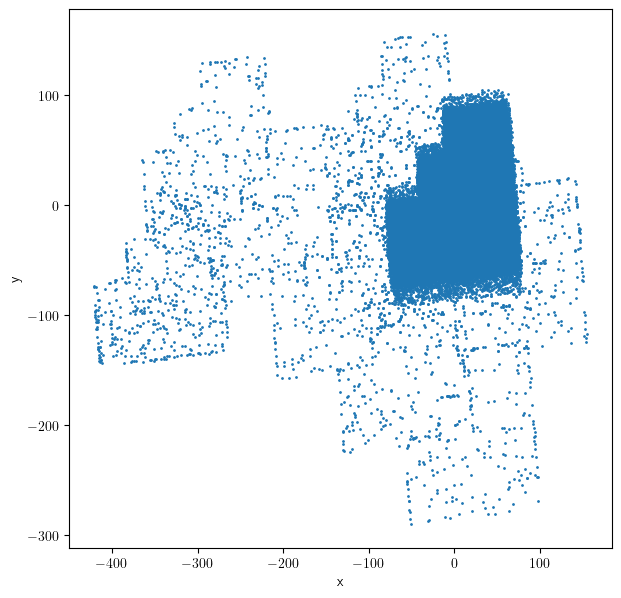

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=1.0)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

100%|██████████| 1/1 [02:55<00:00, 175.12s/it]


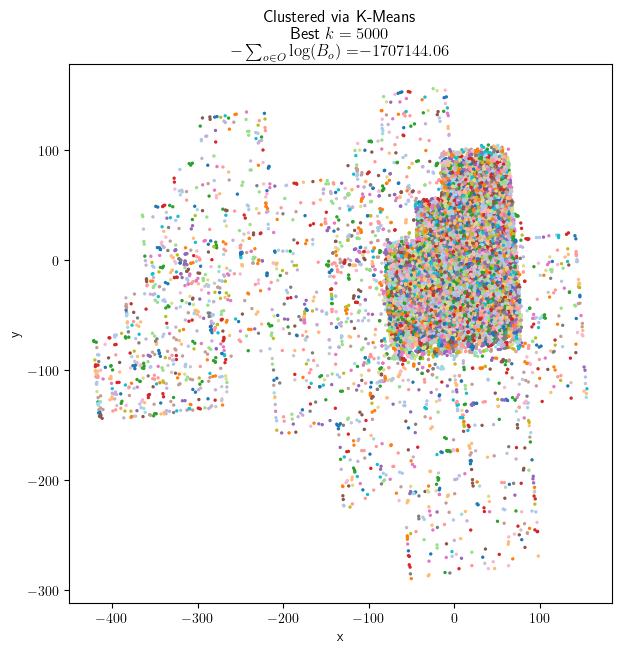

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

best_labels = None
best_k = 0
best_bayes = np.Inf

coords = big_data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = big_data_df["kappa"]

for k in tqdm(range(5000,5001)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X = coords, sample_weight=weights)

    bayes = neg_log_bayes(big_data_df, kmeans.labels_)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = kmeans.labels_
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"$k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [64]:
image_ra_dec = big_data_df.groupby(['ImageID'])[["X", "Y", "Z"]].mean()

image_ra_dec["coord1 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
image_ra_dec["coord2 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

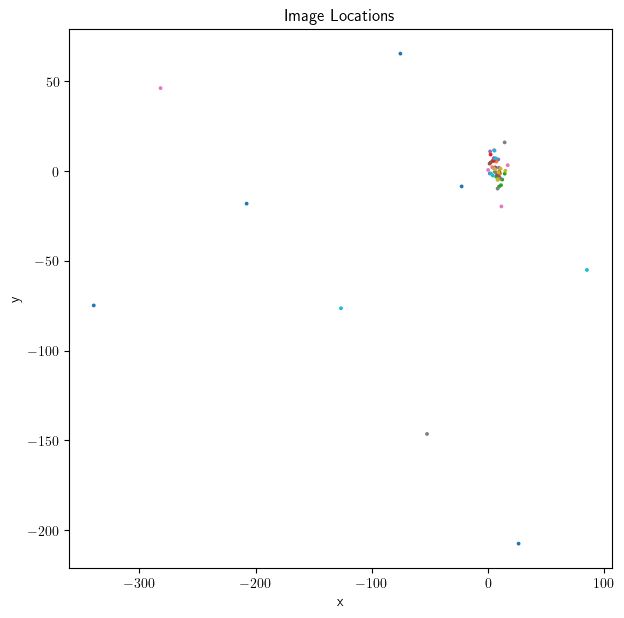

In [68]:
plt.figure(figsize=(7,7))
plt.scatter(image_ra_dec['coord1 (arcseconds)'],
            image_ra_dec['coord2 (arcseconds)'],
            s=3.0, c = image_ra_dec.index, cmap='tab10')
plt.title("Image Locations")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [56]:
import faiss
d = 2 # number of features
ncentroids = 5000

kmeans = faiss.Kmeans(d, ncentroids, niter = 300, verbose = False, gpu = True, nredo = 1)

kmeans.train(coords,weights)

_, labels = kmeans.index.search(coords,1)

neg_log_bayes(big_data_df, list(labels.flatten()))

WARNING clustering 60505 points to 5000 centroids: please provide at least 195000 training points


-1650102.431649264

### COP-Kmeans

In [ ]:
best_labels, best_k, best_bayes = run_cop_kmeans(big_data_df, 100,101)

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

## Match 6000160767697 - Small Data

In [14]:
data_df_2 = load_data("data/match_6000160767697.csv")
data_df_2

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000160767697,2,0,0,6000160767697,-0.770668,-0.025419,-0.63673,0.017658,181.889145,-39.548367,3207.057265,1.364448e+14,32.546941,0.057720,-0.070164
1,6000160767697,2,0,1,6000200049984,-0.770668,-0.025419,-0.63673,0.018430,181.889145,-39.548367,2944.178745,1.252606e+14,32.461417,0.054930,-0.066913
2,6000160767697,2,0,2,6000509549833,-0.770668,-0.025419,-0.63673,0.018430,181.889097,-39.548468,2944.178745,1.252606e+14,32.461417,0.062785,-0.071690
3,6000160767697,2,0,3,6000443790714,-0.770668,-0.025419,-0.63673,0.018773,181.889097,-39.548466,2837.611131,1.207266e+14,32.424550,0.063094,-0.073348
4,6000160767697,2,0,4,6000510780386,-0.770668,-0.025419,-0.63673,0.021173,181.889148,-39.548365,2230.731063,9.490683e+13,32.183917,0.055842,-0.069751
5,6000160767697,2,0,5,6000332395766,-0.770668,-0.025419,-0.63673,0.019287,181.889099,-39.548469,2688.289868,1.143738e+14,32.370493,0.063280,-0.071242
6,6000160767697,2,1,6,6000179832048,-0.770668,-0.025420,-0.63673,0.005460,181.889168,-39.548429,33548.042958,1.427307e+15,34.894566,-0.115376,-0.009996
7,6000160767697,2,1,7,6000435667141,-0.770668,-0.025420,-0.63673,0.005301,181.889172,-39.548426,35580.802793,1.513791e+15,34.953394,-0.116995,-0.009337
8,6000160767697,2,1,8,6000274900085,-0.770668,-0.025420,-0.63673,0.005723,181.889163,-39.548418,30527.297223,1.298789e+15,34.800209,-0.116098,-0.011518
9,6000160767697,2,1,9,6000295587793,-0.770668,-0.025420,-0.63673,0.009706,181.889189,-39.548406,10614.809397,4.516089e+14,33.743838,-0.085463,-0.034497


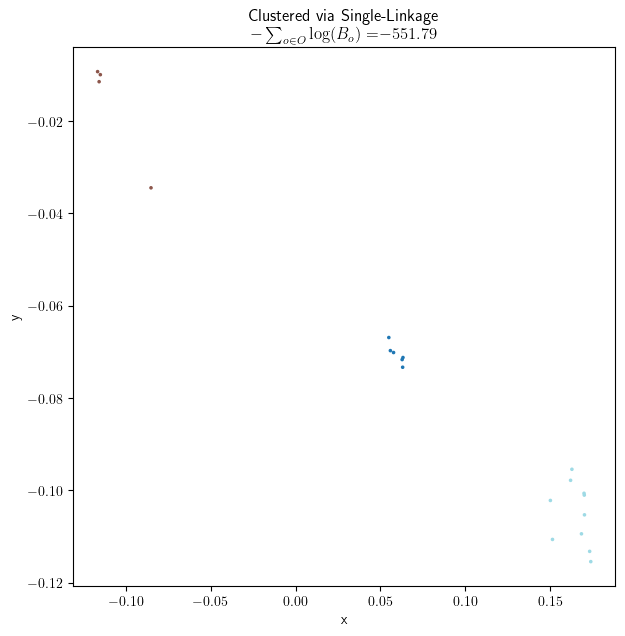

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 80.09it/s]


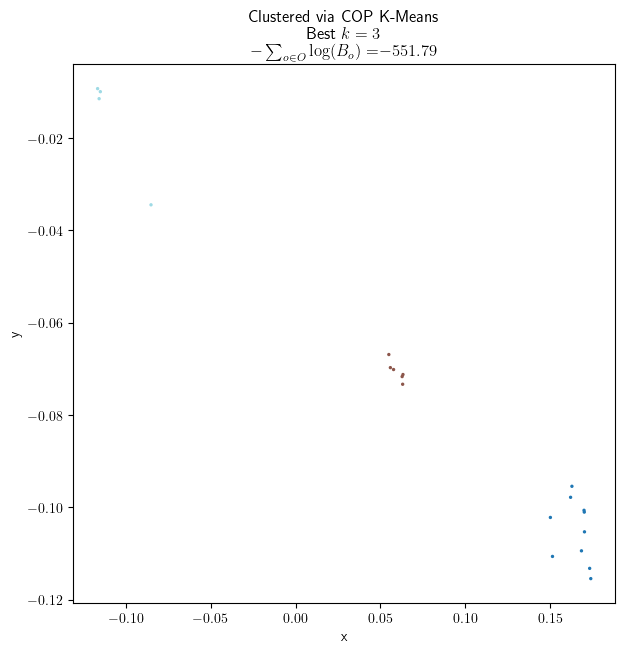

Set parameter NumericFocus to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 346 rows, 260 columns and 946 nonzeros
Model fingerprint: 0x30c54910
Model has 100 quadratic constraints
Variable types: 40 continuous, 220 integer (215 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  QMatrix range    [1e+03, 4e+04]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e-01, 1e+00]
  RHS range        [9e-03, 1e+00]
  QRHS range       [1e+04, 1e+04]
Presolve removed 46 rows and 21 columns
Presolve time: 0.01s
Presolved: 300 rows, 239 columns, 1132 nonzeros
Presolved model has 5 quadratic constraint(s)
Variable types: 45 continuous, 194 integer (194 binary)

Root relaxation: objective -6.318653e+02, 374 iterations, 0.00 seconds (0.00 work

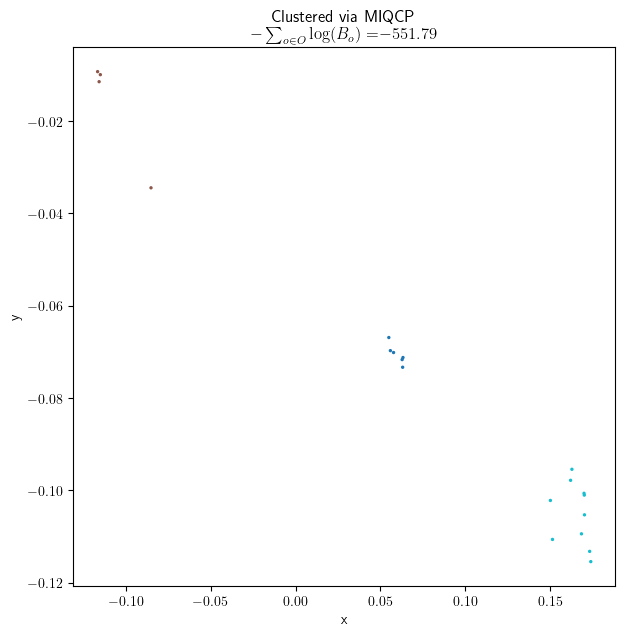

In [22]:
plot_friends_of_friends(data_df_2)
plot_cop_kmeans(data_df_2)
plot_miqcp(data_df_2, 5)

## Match - 6000204755575
This match has more sources from the same image, thus adding constraints to the problem.

In [7]:
data_df_3 = load_data("data/match_6000204755575.csv")
data_df_3

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000204755575,17,0,0,0,-0.609245,0.584830,-0.535532,0.018014,136.171340,-32.379990,3081.530394,1.311042e+14,32.507014,-0.462566,0.322374
1,6000204755575,17,0,1,1,-0.609245,0.584830,-0.535532,0.014955,136.171300,-32.379949,4471.381482,1.902357e+14,32.879285,-0.339688,0.301519
2,6000204755575,17,1,0,2,-0.609240,0.584834,-0.535532,0.009284,136.170901,-32.380026,11601.724041,4.935973e+14,33.832741,0.873614,0.193737
3,6000204755575,17,2,0,3,-0.609241,0.584831,-0.535535,0.013135,136.171105,-32.380175,5796.277435,2.466036e+14,33.138803,0.254267,-0.342248
4,6000204755575,17,3,0,4,-0.609244,0.584829,-0.535535,0.019333,136.171353,-32.380182,2675.468937,1.138283e+14,32.365712,-0.500021,-0.368822
5,6000204755575,17,4,0,5,-0.609243,0.584832,-0.535532,0.024001,136.171126,-32.379984,1735.901316,7.385422e+13,31.933114,0.189571,0.345358
6,6000204755575,17,5,2,6,-0.609243,0.584830,-0.535534,0.023184,136.171246,-32.380112,1860.501853,7.915537e+13,32.002434,-0.153061,-0.114746
7,6000204755575,17,5,1,7,-0.609243,0.584830,-0.535534,0.011579,136.171266,-32.380063,7458.969637,3.173431e+14,33.391005,-0.235482,-0.106740
8,6000204755575,17,5,1,8,-0.609243,0.584830,-0.535534,0.006620,136.171208,-32.380078,22817.098315,9.707573e+14,34.509098,-0.059766,-0.163652
9,6000204755575,17,5,3,9,-0.609243,0.584830,-0.535534,0.015219,136.171321,-32.380213,4317.737444,1.836989e+14,32.844319,-0.180112,-0.221155


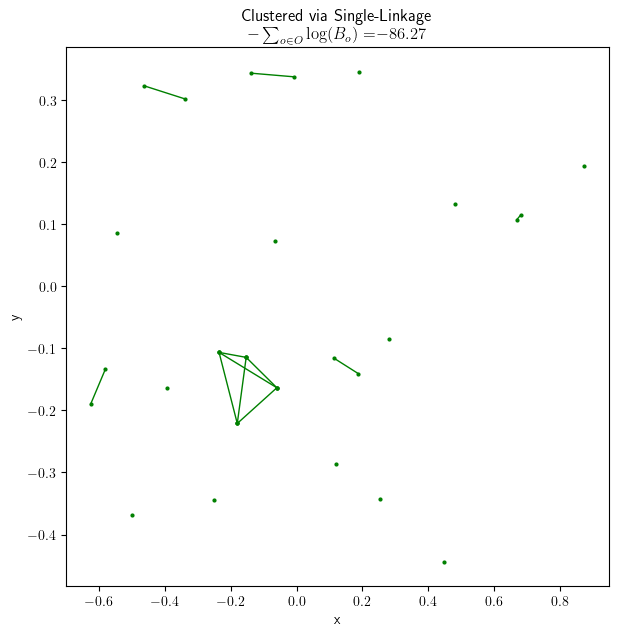

100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


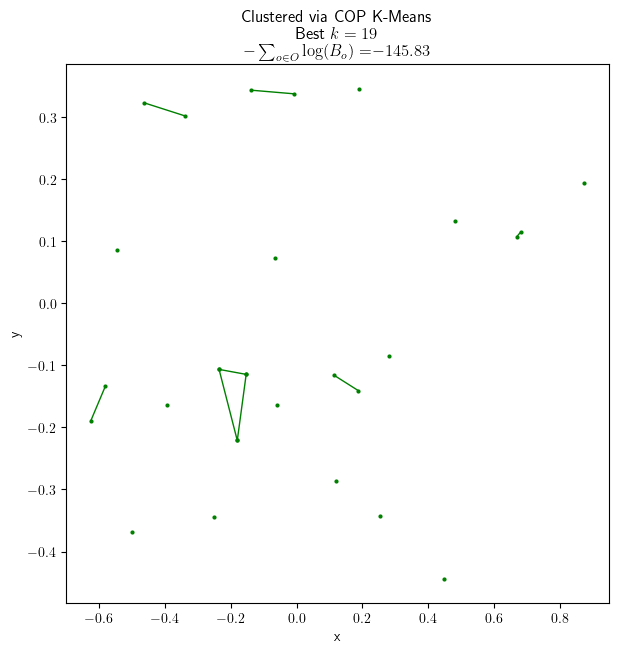

100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


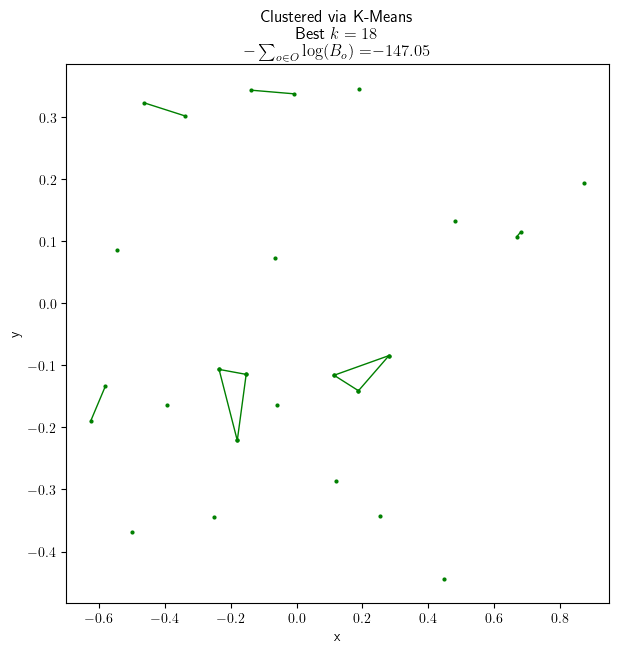

In [17]:
plot_friends_of_friends_lined(data_df_3)
plot_cop_kmeans_lined(data_df_3, num_repeat = 50)
plot_kmeans_lined(data_df_3)

In [8]:
labels = miqcp(data_df_3, max_clusters=12)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Set parameter NumericFocus to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 603 rows, 590 columns and 2449 nonzeros
Model fingerprint: 0x25cbd8e6
Model has 312 quadratic constraints
Variable types: 74 continuous, 516 integer (504 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  QMatrix range    [2e+03, 4e+04]
  QLMatrix range   [1e+00, 6e+04]
  Objective range  [3e-01, 3e+01]
  Bounds range     [8e-01, 1e+00]
  RHS range        [3e-01, 1e+00]
  QRHS range       [5e+04, 6e+04]
Presolve removed 18 rows and 27 columns
Presolve time: 0.01s
Presolved: 585 rows, 563 columns, 3006 nonzeros
Presolved model has 12 quadratic constraint(s)
Variable types: 86 continuous, 477 integer (4